In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from sentence_transformers import SentenceTransformer, util
# import torch
# import mplcursors
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
import json
from langchain.chains.summarize import load_summarize_chain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
import tiktoken
from langchain.docstore.document import Document
from langchain.text_splitter import CharacterTextSplitter

import textwrap
from time import monotonic

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', '00', 'no2', 'no3'])

In [2]:
papers = [
    {
        "title": "Exploring Interactive Color Palettes for Abstraction-Driven Exploratory Image Colorization.",
        "authors": "Xinyu Shi, Mingyu Liu, Ziqi Zhou, Ali Neshati, Ryan Rossi, Jian Zhao",
        "abstract": "Color design is essential in areas such as product, graphic, and fashion design. However, current tools like Photoshop, with their concrete-driven color manipulation approach, often stumble during early ideation, favoring polished end results over initial exploration. We introduced Mondrian as a test-bed for abstraction-driven approach using interactive color palettes for image colorization. Through a formative study with six design experts, we selected three design options for visual abstractions in color design and developed Mondrian where humans work with abstractions and AI manages the concrete aspects. We carried out a user study to understand the benefits and challenges of each abstraction format and compare the Mondrian with Photoshop. A survey involving 100 participants further examined the influence of each abstraction format on color composition perceptions. Findings suggest that interactive visual abstractions encourage a non-linear exploration workflow and an open mindset during ideation, thus providing better creative affordance.",
        "type": "paper",
        "time": "Tue, 14 May | 4:00 PM - 4:15 PM",
        "session": "Colors",
        "venue": "313B"
    },
    {
        "title": "Piet: Facilitating Color Authoring for Motion Graphics Video",
        "authors": "Xinyu Shi, Yinghou Wang, Yun Wang, Jian Zhao",
        "abstract": "Motion graphic (MG) videos are effective and compelling for presenting complex concepts through animated visuals; and colors are important to convey desired emotions, maintain visual continuity, and signal narrative transitions. However, current video color authoring workflows are fragmented, lacking contextual previews, hindering rapid theme adjustments, and not aligning with designers’ progressive authoring flows. To bridge this gap, we introduce Piet, the first tool tailored for MG video color authoring. Piet features an interactive palette to visually represent color distributions, support controllable focus levels, and enable quick theme probing via grouped color shifts. We interviewed 6 domain experts to identify the frustrations in current tools and inform the design of Piet. An in-lab user study with 13 expert designers showed that Piet effectively simplified the MG video color authoring and reduced the friction in creative color theme exploration.",
        "type": "paper",
        "award": "Best Paper Award",
        "time": "Tue, 14 May | 5:00 PM - 5:15 PM",
        "session": "Colors",
        "venue": "313B"
    },
    {
        "title": "EmoWear: Exploring Emotional Teasers for Voice Message Interaction on Smartwatches",
        "authors": "Pengcheng An, Jiawen Stefanie Zhu, Zibo Zhang, Yifei Yin, Qingyuan Ma, Che Yan, Linghao Du, Jian Zhao",
        "abstract": "Voice messages, by nature, prevent users from gauging the emotional tone without fully diving into the audio content. This hinders the shared emotional experience at the pre-retrieval stage. Research scarcely explored 'Emotional Teasers'—pre-retrieval cues offering a glimpse into an awaiting message's emotional tone without disclosing its content. We introduce EmoWear, a smartwatch voice messaging system enabling users to apply 30 animation teasers on message bubbles to reflect emotions. EmoWear eases senders' choice by prioritizing emotions based on semantic and acoustic processing. EmoWear was evaluated in comparison with a mirroring system using color-coded message bubbles as emotional cues (N=24). Results showed EmoWear significantly enhanced emotional communication experience in both receiving and sending messages. The animated teasers were considered intuitive and valued for diverse expressions. Desirable interaction qualities and practical implications are distilled for future design. We thereby contribute both a novel system and empirical knowledge concerning emotional teasers for voice messaging.",
        "type": "paper",
        "time": "Thu, 16 May | 9:00 AM - 9:15 AM",
        "session": "Emotions and User Experience",
        "venue": "324"
    },
    {
        "title": "CoPrompt: Supporting Prompt Sharing and Referring in Collaborative Natural Language Programming",
        "authors": "Li Feng†, Ryan Yen†, Yuzhe You, Mingming Fan, Jian Zhao, Zhicong Lu",
        "abstract": "Natural language (NL) programming has become more approachable due to the powerful code-generation capability of large language models (LLMs). This shift to using NL to program enhances collaborative programming by reducing communication barriers and context-switching among programmers from varying backgrounds. However, programmers may face challenges during prompt engineering in a collaborative setting as they need to actively keep aware of their collaborators' progress and intents. In this paper, we aim to investigate ways to assist programmers’ prompt engineering in a collaborative context. We first conducted a formative study to understand the workflows and challenges of programmers when using NL for collaborative programming. Based on our findings, we implemented a prototype, CoPrompt, to support collaborative prompt engineering by providing referring, requesting, sharing, and linking mechanisms. Our user study indicates that CoPrompt assists programmers in comprehending collaborators' prompts and building on their collaborators’ work, reducing repetitive updates and communication costs.",
        "type": "paper",
        "time": "Wed, 15 May | 9:45 AM - 10:00 AM",
        "session": "Supporting Programmers and Learners B",
        "venue": "310 Lili'u Theater"
    },
    {
        "title": "Exploring Visualizations for Precisely Guiding Bare Hand Gestures in Virtual Reality",
        "authors": "Xizi Wang, Ben Lafreniere, Jian Zhao",
        "abstract": "Bare hand interaction in augmented or virtual reality (AR/VR) systems, while intuitive, often results in errors and frustration. However, existing methods, such as a static icon or a dynamic tutorial, can only inform simple and coarse hand gestures and lack corrective feedback. This paper explores various visualizations for enhancing precise hand interaction in VR. Through a comprehensive two-part formative study with 11 participants, we identified four types of essential information for visual guidance and designed different visualizations that manifest these information types. We further distilled four visual designs and conducted a controlled lab study with 15 participants to assess their effectiveness for various single- and double-handed gestures. Our results demonstrate that visual guidance significantly improved users' gesture performance, reducing time and workload while increasing confidence. Moreover, we found that the visualization did not disrupt most users' immersive VR experience or their perceptions of hand tracking and gesture recognition reliability.",
        "type": "paper",
        "time": "Mon, 13 May | 2:30 PM - 2:45 PM",
        "session": "Interaction and Perception in Immersive Environments",
        "venue": "317"
    },
    {
        "title": "To Search or To Gen? Exploring the Synergy between Generative AI and Web Search in Programming",
        "authors": "Ryan Yen, Nicole Sultanum, Jian Zhao",
        "abstract": "The convergence of generative AI and web search is reshaping problem-solving for programmers. However, the lack of understanding regarding their interplay in the information-seeking process often leads programmers to perceive them as alternatives rather than complementary tools. To analyze this interaction and explore their synergy, we conducted an interview study with eight experienced programmers. Drawing from the results and literature, we have identified three major challenges and proposed three decision-making stages, each with its own relevant factors. Additionally, we present a comprehensive process model that captures programmers' interaction patterns. This model encompasses decision-making stages, the information-foraging loop, and cognitive activities during system interaction, offering a holistic framework to comprehend and optimize the use of these convergent tools in programming.",
        "type": "late-breaking work",
        "time": "Tue, 14 May | 10:20 AM - 11:00 AM",
        "session": "Late-Breaking Work: Generative AI",
        "venue": "Kamehameha Exhibit Hall"
    }
]

In [34]:
# read the ipynb file as JSON
with open("../raw_data/stacked-regressions-top-4-on-leaderboard.ipynb") as f:
    data = json.load(f)
    
data.keys()

dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])

In [35]:
# list all cells.cell_type unique values
cell_types = set([cell["cell_type"] for cell in data["cells"]])
cell_types

{'code', 'markdown'}

In [36]:
# get all the code cells' source (concatenated) and the outputs[0].data (text/plain and text/html if exists)

all_code = []
all_output = []

for cell in data["cells"]:
    if cell["cell_type"] == "code":
        all_code.append("".join(cell["source"]))
        if cell["outputs"]:
            if cell["outputs"][0] and "data" in cell["outputs"][0]:
                if "text/plain" in cell["outputs"][0]["data"]:
                    plain_texts = cell["outputs"][0]["data"]["text/plain"]
                    all_output.append("".join(plain_texts))
                if "text/html" in cell["outputs"][0]["data"]:
                    html_texts = cell["outputs"][0]["data"]["text/html"]
                    all_output.append("".join(html_texts))
                    
                    
len(all_code), len(all_output)

(65, 12)

In [37]:
model = SentenceTransformer('all-MiniLM-L6-v2')

BATCH_SIZE = 128
embeddings_code = []
for i in range(0, len(all_code), BATCH_SIZE):
    embeddings_code.extend(model.encode(all_code[i:i+BATCH_SIZE]))
    
embeddings_code = np.array(embeddings_code)

In [85]:
umap = UMAP(n_components=2)
umap_embeddings_code = umap.fit_transform(embeddings_code)

kmeans = KMeans(n_clusters=4, random_state=0).fit(embeddings_code)

In [76]:
# # summarize what each code cells trying to do in plain text
# summarize_chain = load_summarize_chain()
# chat_model = ChatOpenAI()
# prompt = PromptTemplate("summarize_code")

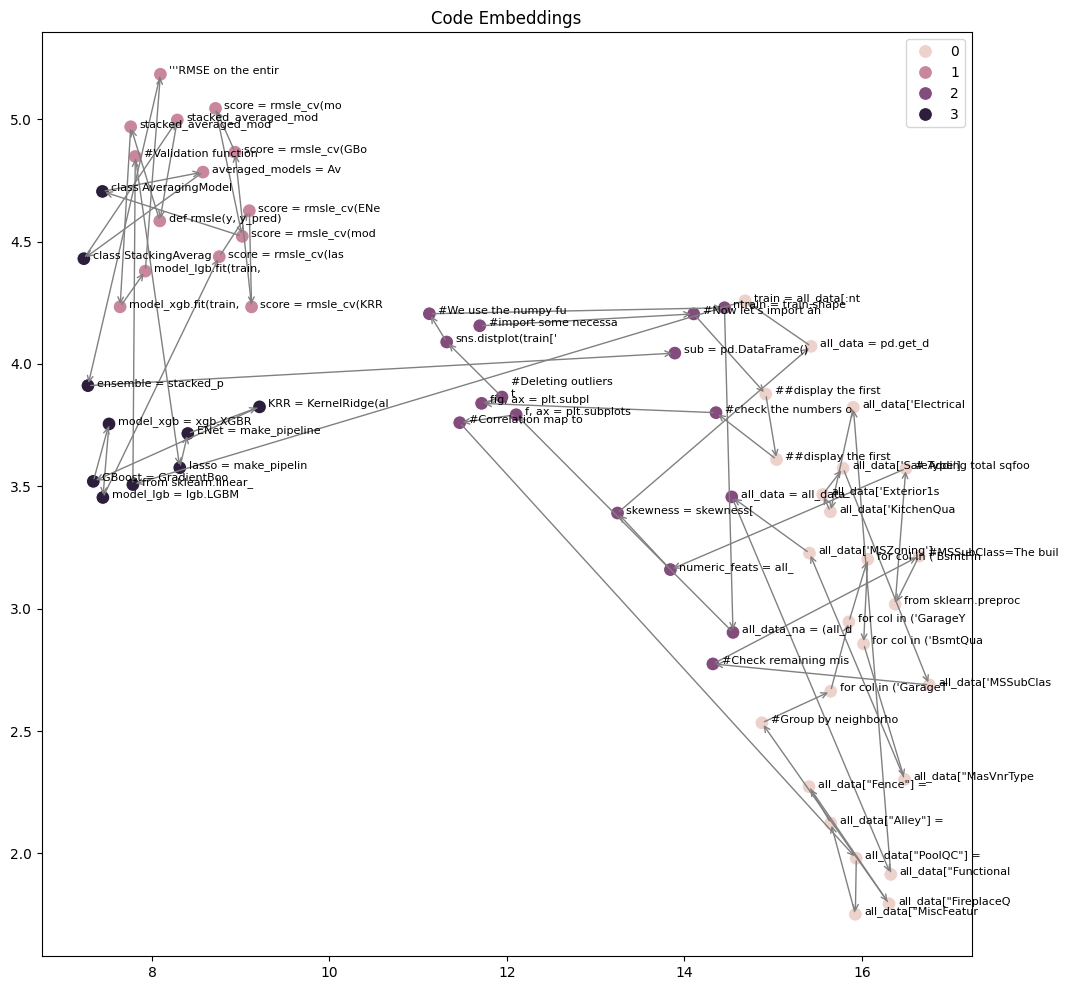

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# arrow = the temporal order of the code cells
arrows_code = [(umap_embeddings_code[i], umap_embeddings_code[i+1]) for i in range(len(umap_embeddings_code)-1)]

# add arrows
avg_length = np.mean([np.linalg.norm(end - start) for start, end in arrows_code])
std_length = np.std([np.linalg.norm(end - start) for start, end in arrows_code])
for start, end in arrows_code:
    # if np.linalg.norm(end - start) > avg_length * 2:
    #     continue
    ax.annotate("", xy=end, xytext=start, arrowprops=dict(arrowstyle="->", lw=1, color="gray"))
    
    
sns.scatterplot(x=umap_embeddings_code[:, 0], y=umap_embeddings_code[:, 1], hue=kmeans.labels_, ax=ax, s=100)

for i, txt in enumerate(all_code):
    ax.annotate(txt[:20], (umap_embeddings_code[i, 0] + .1, umap_embeddings_code[i, 1]), fontsize=8)
    

ax.set_title("Code Embeddings")
plt.show()

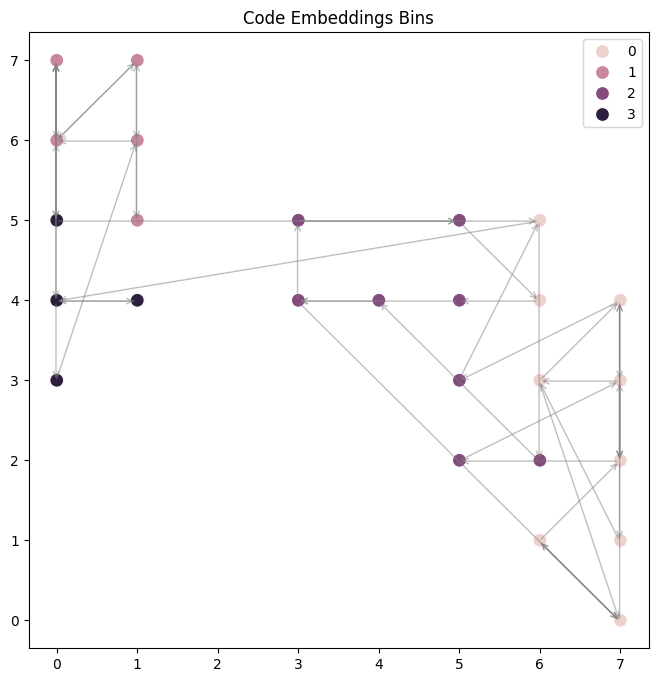

In [158]:
umap_x_bins = pd.cut(umap_embeddings_code[:, 0], bins=8, labels=False)
umap_y_bins = pd.cut(umap_embeddings_code[:, 1], bins=8, labels=False)

# plot bins as scatter plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sns.scatterplot(x=umap_x_bins, y=umap_y_bins, hue=kmeans.labels_, ax=ax, s=100)
# draw arrows
arrows_bins = [(umap_x_bins[i], umap_y_bins[i], umap_x_bins[i+1], umap_y_bins[i+1]) for i in range(len(umap_x_bins)-1)]
for start_x, start_y, end_x, end_y in arrows_bins:
    # if np.linalg.norm([end_x - start_x, end_y - start_y]) > avg_length * 5:
    #     continue
    ax.annotate("", xy=(end_x-.01, end_y-.01), xytext=(start_x-.01, start_y-.01), arrowprops=dict(arrowstyle="->", lw=1, color="gray", alpha=.5))

    
ax.set_title("Code Embeddings Bins")
plt.show()

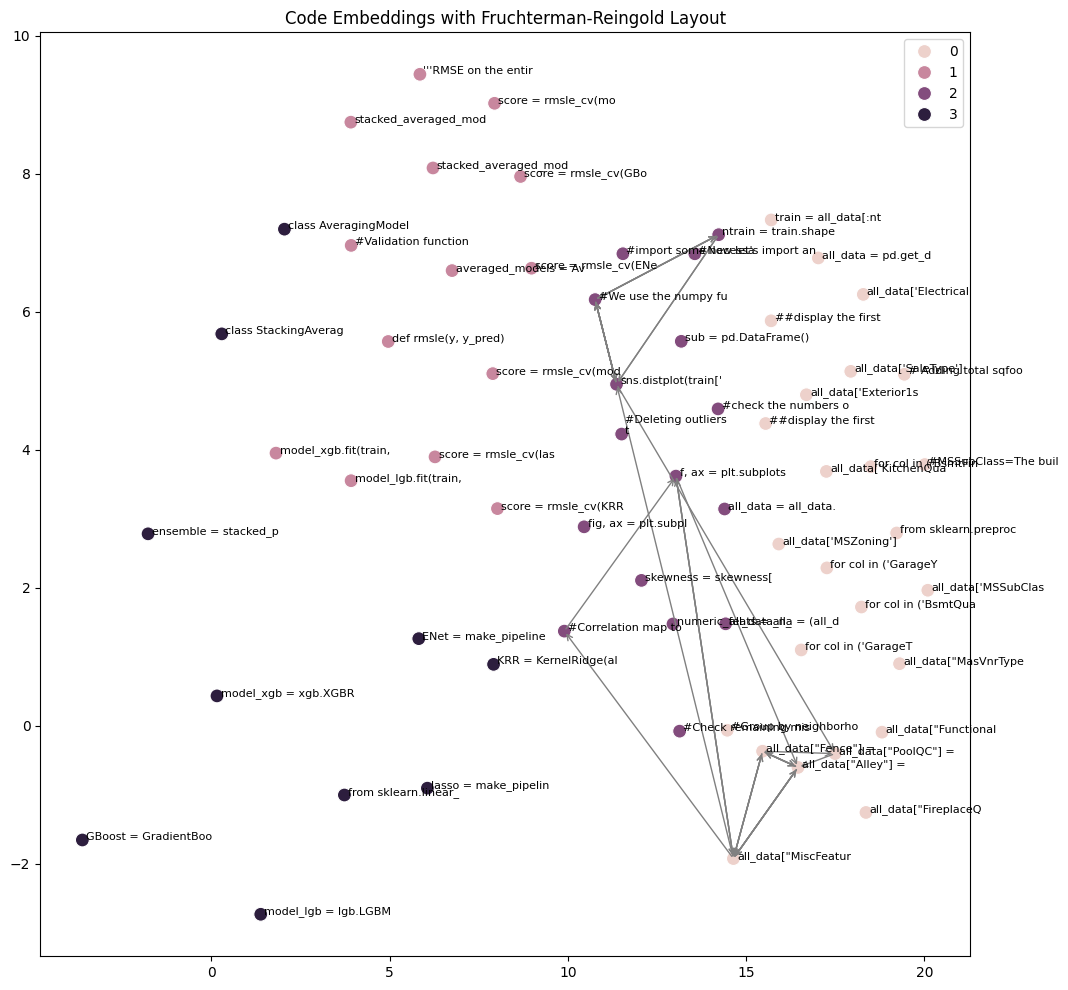

In [92]:
def euclidean(a, b):
    return np.linalg.norm(a - b)


def fr_layout(points, arrows, k=1, iterations=50, delta=0.1):
    pos = np.copy(points)
    for _ in range(iterations):
        displacement = np.zeros_like(pos)
        # Calculate repulsive forces
        for i in range(len(pos)):
            for j in range(len(pos)):
                if i != j:
                    displacement[i] += (pos[i] - pos[j]) / euclidean(pos[i], pos[j]) ** 2

        # Calculate spring forces
        for start, end in arrows:
            start_x, start_y = start
            end_x, end_y = end
            start_x, start_y, end_x, end_y = int(start_x), int(start_y), int(end_x), int(end_y)
            displacement[start_x, 0] += (pos[end_x, 0] - pos[start_x, 0]) * k * (euclidean(pos[start_x], pos[end_x]) - avg_length)
            displacement[start_y, 1] += (pos[end_y, 1] - pos[start_y, 1]) * k * (euclidean(pos[start_y], pos[end_y]) - avg_length)

        # Limit the maximum displacement to the temperature delta
        for i in range(len(pos)):
            length = euclidean(pos[i], np.zeros_like(pos[i]))
            displacement[i] *= min(delta, delta / length)

        # Update positions
        pos += displacement

    return pos

umap_fr_embeddings_code = fr_layout(umap_embeddings_code, arrows_code, k=0.1, iterations=50, delta=0.1)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# add arrows
for start, end in arrows_code:
    ax.annotate("", xy=umap_fr_embeddings_code[int(end[0])], xytext=umap_fr_embeddings_code[int(start[0])], arrowprops=dict(arrowstyle="->", lw=1, color="gray"))

sns.scatterplot(x=umap_fr_embeddings_code[:, 0], y=umap_fr_embeddings_code[:, 1], hue=kmeans.labels_, ax=ax, s=100)

for i, txt in enumerate(all_code):
    ax.annotate(txt[:20], (umap_fr_embeddings_code[i, 0] + .1, umap_fr_embeddings_code[i, 1]), fontsize=8)

ax.set_title("Code Embeddings with Fruchterman-Reingold Layout")
plt.show()
